In [ ]:
# Datos: http://saludata.saludcapital.gov.co/osb/datos_abiertos_osb/enf-transmisibles/OSB_EnfTransm-COVID-19.csv

In [25]:
import requests
import pandas as pd
#import geopandas as gpd
from google.cloud import storage

In [26]:
URL = 'http://saludata.saludcapital.gov.co/osb/datos_abiertos_osb/enf-transmisibles/OSB_EnfTransm-COVID-19.csv'
FILEPATH = './data/covid19_bogota_raw.csv'

In [27]:
r = requests.get( URL, stream = True )

with open( FILEPATH, 'wb' ) as f:
    f.write( r.content )

In [28]:
# Loading the data
covid_bog = pd.read_csv( FILEPATH, encoding = 'ISO-8859-1', sep = ';', skiprows = 4, skipfooter = 2 )

<ipython-input-28-89320a379672>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  covid_bog = pd.read_csv( FILEPATH, encoding = 'ISO-8859-1', sep = ';', skiprows = 4, skipfooter = 2 )


In [29]:
covid_bog.columns

Index(['ID de caso', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico',
       'Ciudad de residencia', 'Localidad de residencia', 'Edad',
       'Unidad de medida de la edad', 'Sexo', 'Tipo de caso', 'Ubicación',
       'Estado'],
      dtype='object')

In [30]:
covid_bog.shape

(146110, 11)

In [31]:
covid_bog[ 'Fecha de inicio de síntomas' ] = pd.to_datetime( covid_bog[ 'Fecha de inicio de síntomas' ], format = '%d/%m/%Y', errors = 'coerce' )

In [32]:
covid_bog[ 'Fecha de diagnóstico' ] = pd.to_datetime( covid_bog[ 'Fecha de diagnóstico' ], format = '%d/%m/%Y' )

In [33]:
covid_bog[ 'Localidad de residencia' ].replace( { 'Santa Fe': 'Santa Fé' }, inplace = True )

In [34]:
covid_bog[ 'Atencion' ] = covid_bog[ 'Ubicación' ].str.strip()
del covid_bog[ 'Ubicación' ]

In [35]:
covid_bog[ 'Estado' ] = covid_bog[ 'Estado' ].str.strip()

In [36]:
covid_bog.dtypes

ID de caso                            float64
Fecha de inicio de síntomas    datetime64[ns]
Fecha de diagnóstico           datetime64[ns]
Ciudad de residencia                   object
Localidad de residencia                object
Edad                                  float64
Unidad de medida de la edad           float64
Sexo                                   object
Tipo de caso                           object
Estado                                 object
Atencion                               object
dtype: object

In [37]:
def get_age_group( x ):
    if x <= 19:
        return '0 - 19'
    elif x > 19 and x <= 39:
        return '20 - 39'
    elif x > 39 and x <= 59:
        return '40 - 59'
    elif x > 59 and x <= 79:
        return '60 - 79'
    elif x > 79:
          return '80+'
    else:
        return None

covid_bog[ 'Grupo de edad' ] = covid_bog[ 'Edad' ].apply( get_age_group )

In [38]:
covid_bog.replace( { 'Fallecido (No aplica, No causa Directa)': 'Fallecido', 'Fallecido(No aplica': 'Fallecido', 'fallecido': 'Fallecido', 'hospital': 'Hospital', 'leve': 'Leve' }, inplace = True )

In [39]:
covid_bog.rename( columns = { 'ID de caso': 'ID_caso', 'Fecha de inicio de síntomas': 'Fecha_inicio_sintomas', 'Fecha de diagnóstico': 'Fecha_diagnostico', 'Ciudad de residencia': 'Ciudad', 'Localidad de residencia': 'Localidad', 'Tipo de caso': 'Tipo', 'Ubicación': 'Atencion', 'Grupo de edad': 'Grupo_de_edad' }, inplace = True )

In [40]:
covid_bog = covid_bog[ [ 'ID_caso', 'Fecha_inicio_sintomas', 'Fecha_diagnostico', 'Ciudad', 'Localidad', 'Edad', 'Sexo', 'Tipo', 'Atencion', 'Estado', 'Grupo_de_edad' ] ]

In [41]:
covid_bog.dtypes

ID_caso                         float64
Fecha_inicio_sintomas    datetime64[ns]
Fecha_diagnostico        datetime64[ns]
Ciudad                           object
Localidad                        object
Edad                            float64
Sexo                             object
Tipo                             object
Atencion                         object
Estado                           object
Grupo_de_edad                    object
dtype: object

In [42]:
covid_bog.tail()

,ID_caso,Fecha_inicio_sintomas,Fecha_diagnostico,Ciudad,Localidad,Edad,Sexo,Tipo,Atencion,Estado,Grupo_de_edad
146105,146106.0,2020-07-27,2020-08-11,Sin dato,Sin dato,62.0,M,En estudio,Casa,Leve,60 - 79
146106,146107.0,2020-07-28,2020-08-12,Sin dato,Sin dato,47.0,F,En estudio,Casa,Leve,40 - 59
146107,146108.0,2020-07-16,2020-07-31,Bogotá,Los Mártires,35.0,M,En estudio,Casa,Leve,20 - 39
146108,146109.0,2020-07-27,2020-08-11,Bogotá,Suba,28.0,M,En estudio,Casa,Leve,20 - 39
146109,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


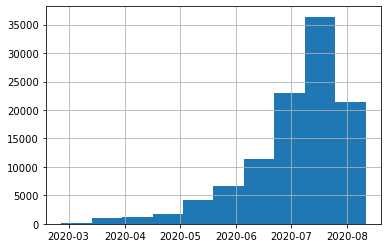

In [43]:
covid_bog[ 'Fecha_inicio_sintomas' ].hist()

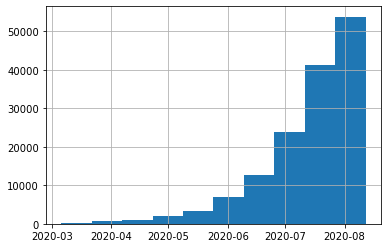

In [44]:
covid_bog[ 'Fecha_diagnostico' ].hist()

In [45]:
covid_bog[ 'Atencion' ].unique()

array(['Casa', 'Fallecido', 'Hospital', 'Hospital UCI', nan], dtype=object)

In [46]:
covid_bog[ 'Estado' ].unique()

array(['Recuperado', 'Fallecido', 'Grave', 'Moderado', 'Leve', nan],
      dtype=object)

In [47]:
#covid_bog.to_csv( './data/covid19_bogota.csv', index = False )

In [48]:
#DataFrame to CSV
csv_data=covid_bog.to_csv(index=False)

#Client, bucket and blob to acces gcloud
client= storage.Client()
bucket= client.get_bucket('siscovid')
blob=bucket.blob('covid19_bogota.csv')

#Uploads the file to gcloud
blob.upload_from_string(data=csv_data, content_type='text/csv')